In [1]:
import numpy as np
import pandas as pd
from scipy.stats import beta, cauchy, gamma, gaussian_kde
import time  # Pour suivre le temps d'exécution
import matplotlib.pyplot as plt

In [8]:
def prior(n, hyper):
    X_1 = beta.rvs(hyper[0], hyper[1] + hyper[2], size=n)
    Temp = beta.rvs(hyper[1], hyper[2], size=n)
    X_2 = Temp * (1 - X_1)
    R_1 = X_1 - X_2
    R_2 = 2 * (X_1 + X_2) - 1
    return np.column_stack((R_1, R_2))

def simu(tht1, tht2, sigm, n):
    A = np.random.normal(0, sigm, size=n + 30)
    U = A[2:(n + 2)]
    V = A[1:(n + 1)]
    W = A[0:n]
    return U + tht1 * V + tht2 * W

def distautcor(Z, X):
    p = len(Z)
    a2 = np.sum(Z[2:p] * Z[0:(p - 2)])
    b2 = np.sum(X[2:p] * X[0:(p - 2)])
    a1 = np.sum(Z[1:p] * Z[0:(p - 1)])
    b1 = np.sum(X[1:p] * X[0:(p - 1)])
    return np.sqrt((a2 - b2)**2 + (a1 - b1)**2)


In [9]:
def ABCbas(X, N, sigm, hyper):
    res = prior(N, hyper)
    dist = np.apply_along_axis(lambda x: distautcor(X - np.mean(X), simu(x[0], x[1], sigm, len(X))), 1, res)
    return res[np.argmin(dist), :]

def statdir(U):
    q = (U[:, 1] + 2 * U[:, 0] + 1) / 4
    q = np.where(q != 0, q, np.finfo(float).eps)  # Remplacer les zéros par une très petite valeur
    
    return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
    
def ABChaut(Q1, Q2, L):
    Q = np.column_stack((Q1, Q2))
    hyper = np.random.exponential(size=(L, 3))
    dist = np.apply_along_axis(lambda x: np.sum((statdir(prior(len(Q1), x)) - statdir(Q))**2), 1, hyper)
    return hyper[np.argmin(dist), :]

def ABCsigm(Dat, j, parh1, parh2, parsigm1, parsigm2, N):
    dist = np.zeros(N)
    n = Dat.shape[0]
    w = np.arange(0, n, 3)
    si = 1 / gamma.rvs(parsigm1, scale=parsigm2, size=N)
    for i in range(N):
        dist[i] = np.abs(np.var(simu(parh1[j], parh2[j], si[i], n)[w]) - np.var(Dat[w, j]))
    return si[np.argmin(dist)]

def ABCsigmhaut(sigm, Q):
    dist = np.zeros(Q)
    n = len(sigm)
    pri = np.abs(cauchy.rvs(size=2*Q)).reshape((Q, 2))
    for i in range(Q):
        h = pri[i]
        
        # Générer une valeur pour h[0] et h[1]
        while True:
            try:
                y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
                break
            except OverflowError:
                # Si une erreur de dépassement de capacité se produit, ajustez les paramètres h[0] et h[1]
                h = np.abs(cauchy.rvs(size=2))
        
        dist[i] = np.abs(np.sum(np.log(y)) - np.sum(np.log(sigm))) + np.abs(np.sum(y) - np.sum(sigm))
    return pri[np.argmin(dist), :]


In [10]:
def GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max):
    
    start_time = time.time()
    etapes_realisees = 0 
    hyper = np.zeros((Npts, 3))
    par1 = np.full((Npts, X.shape[1]), np.nan)
    par2 = np.full((Npts, X.shape[1]), np.nan)
    sigm = np.full((Npts, X.shape[1]), np.nan)
    hypersigm = np.full((Npts, 2), np.nan)
    
    simu_results = []  # Liste pour stocker les simulations
    distances_par = []  # Liste pour stocker les distances
    histeps = []  # Liste pour stocker l'historique des epsilons
    eps = float('inf')  # Initialiser epsilon à l'infini

    for i in range(Npts):
        # Vérifier si le temps maximum est dépassé
        current_time = time.time()
        if current_time - start_time > temps_max:
            print(f"Temps maximum d'exécution de {temps_max} secondes atteint à l'étape {i}.")
            break  # Sortir de la boucle principale si le temps maximum est atteint
        
        if i == 0:  # Initialisation spécifique pour la première itération
            hyper[i, :] = np.random.exponential(size=3)
            hypersigm[i, :] = np.abs(cauchy.rvs(size=2))
            sigm[i, :] = 1 / gamma.rvs(hypersigm[i, 0], scale=hypersigm[i, 1], size=X.shape[1])
        
        dist_i = []
        
        for j in range(X.shape[1]):
            if i > 0:  # Pour les itérations suivantes, utilisez les valeurs mises à jour
                U = ABCbas(X[:, j], N, sigm[i - 1, :], hyper[i - 1, :])
            else:  # Pour la première itération, utilisez les valeurs initiales
                U = ABCbas(X[:, j], N, sigm[i, :], hyper[i, :])
            par1[i, j] = U[0]
            par2[i, j] = U[1]
            if i < Npts - 1:  # Éviter de calculer pour la dernière itération où ce n'est pas nécessaire
                sigm[i + 1, j] = ABCsigm(X, j, par1[i, :], par2[i, :], hypersigm[i, 0], hypersigm[i, 1], P)
            simu_j = simu(par1[i, j], par2[i, j], sigm[i, j], X.shape[0])
            simu_results.append(simu_j)
            dist = np.abs(np.var(simu_j) - np.var(X[:, j]))
            dist_i.append(dist)

        iteration_end_time = time.time()  # Enregistrer le temps de fin de l'itération

        eps = min(eps, max(dist_i))  # Mettre à jour epsilon avec la distance maximale de cette itération si elle est plus petite
        histeps.append(eps)  # Ajouter la valeur actuelle d'epsilon à l'historique
        if eps <= objectifeps:  # Vérifier si l'objectif est atteint
            print(f"Objectif epsilon atteint : {eps} <= {objectifeps}")
            break  # Sortir de la boucle si l'objectif est atteint

        if i < Npts - 1:  # Éviter de calculer pour la dernière itération où ce n'est pas nécessaire
            hyper[i + 1, :] = ABChaut(par1[i, :], par2[i, :], M)
            hypersigm[i + 1, :] = ABCsigmhaut(sigm[i, :], P2)
        distances_par.append(dist_i)
    
    total_time = time.time() - start_time  # Calculer le temps total d'exécution
    
    # À la fin de la fonction, avant de retourner les résultats
    if etapes_realisees > 0:  # Si l'algorithme s'est arrêté en raison du temps maximum
        print(f"Nombre d'étapes réalisées avant l'arrêt : {etapes_realisees}")
    
    # Supprimer les lignes remplies de nan ou de 0 
    par1 = par1[~np.isnan(par1).all(axis=1)]
    par2 = par2[~np.isnan(par2).all(axis=1)]
    hyper = hyper[~(np.isnan(hyper).all(axis=1) | np.all(hyper == 0, axis=1))]
    hypersigm = hypersigm[~np.isnan(hypersigm).all(axis=1)]

    resultats = {
        "Paramètre_1": par1,
        "Paramètre_2":par2,
        'Hyperparamètres': hyper,
        'Hypersigma': hypersigm,
        'Historique des epsilons': histeps
    }

    # Pour imprimer les résultats avec des titres
    for titre, valeur in resultats.items():
        print(f"{titre}:")
        print(valeur)
        print("\n")  # Ajoute un espace entre chaque section pour la clarté

    return resultats  # Retourne le dictionnaire de résultats

In [24]:
def distance(X, N, M, P, P2, Npts, objectifeps, temps_max, par1_real, par2_real, hyper_real, hypersigm_real):
    # Exécuter GibbsABC pour obtenir les valeurs estimées
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max)

    par1_estime = np.mean(resultats["Paramètre_1"], axis=0)
    par2_estime = np.mean(resultats["Paramètre_2"], axis=0)
    hyper_estime = np.mean(resultats["Hyperparamètres"], axis=0)
    hypersigm_estime = np.mean(resultats["Hypersigma"], axis=0)

    # Calculer les distances euclidiennes
    distance_par1 = np.linalg.norm(par1_estime - par1_real)
    distance_par2 = np.linalg.norm(par2_estime - par2_real)
    distance_hyper = np.linalg.norm(hyper_estime - hyper_real)
    distance_hypersigm = np.linalg.norm(hypersigm_estime - hypersigm_real)

    # Retourner les distances dans un dictionnaire
    return {
        'Distance Paramètre 1': distance_par1,
        'Distance Paramètre 2': distance_par2,
        'Distance Hyperparamètres': distance_hyper,
        'Distance Hypersigma': distance_hypersigm
    }


In [25]:
l=50
X = np.random.normal(-5, 1, (20, l)) #data
N=1000 #nombre d'échantillons générés pour chaque simulation individuelle
P=100 #nombre de simulations pour sigma
P2=100 #nombre de simulations pour l'hypersigma
M=100 #nombre de simulations pour l'hyperparamètre
Npts=100 #nombre total d'itérations de l'algorithme global
objectifeps=0.1
hyper_real= [1,2,3]
hypersigm_real= [1,1]
par1_real=2
par2_real=3
temps_max=10

In [26]:
toyG = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max)
toyG

C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:10: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:37: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)


Temps maximum d'exécution de 10 secondes atteint à l'étape 4.
Paramètre_1:
[[-0.68117549  0.05019328 -0.13058575 -0.00606253 -0.11228192 -0.62752698
  -0.43273021  0.46292474 -0.61416282  0.13233466  0.09469678  0.13225877
   0.12509387 -0.36865951  0.2398721   0.85657148  0.83106286 -0.43560915
   0.53162799  0.70807457 -0.18938428 -0.52736691 -0.48456799  0.18516812
  -0.30114057  0.19862949 -0.65424293  0.06029387  0.64391631  0.63320591
   0.18747168 -0.1662592   0.07937097  0.17713523  0.00235205  0.03674161
  -0.29114336  0.09902074  0.04915141 -0.13224639 -0.62757442  0.58104719
  -0.40133574 -0.42980427  0.07229681 -0.36819882 -0.07894614  0.682404
   0.35975556  0.56996927]
 [-0.13037966  0.10157831  0.04273787  0.09867573 -0.12997178  0.09377978
  -0.37005733  0.61875134  0.07166181  0.15973579  0.00353123  0.04156951
  -0.05689873 -0.4722767  -0.0753395   0.49476143  0.37235616 -0.19134195
   0.17094549  0.82427093 -0.29031623 -0.16671865 -0.16719142  0.0065389
  -0.04401942

{'Paramètre_1': array([[-0.68117549,  0.05019328, -0.13058575, -0.00606253, -0.11228192,
         -0.62752698, -0.43273021,  0.46292474, -0.61416282,  0.13233466,
          0.09469678,  0.13225877,  0.12509387, -0.36865951,  0.2398721 ,
          0.85657148,  0.83106286, -0.43560915,  0.53162799,  0.70807457,
         -0.18938428, -0.52736691, -0.48456799,  0.18516812, -0.30114057,
          0.19862949, -0.65424293,  0.06029387,  0.64391631,  0.63320591,
          0.18747168, -0.1662592 ,  0.07937097,  0.17713523,  0.00235205,
          0.03674161, -0.29114336,  0.09902074,  0.04915141, -0.13224639,
         -0.62757442,  0.58104719, -0.40133574, -0.42980427,  0.07229681,
         -0.36819882, -0.07894614,  0.682404  ,  0.35975556,  0.56996927],
        [-0.13037966,  0.10157831,  0.04273787,  0.09867573, -0.12997178,
          0.09377978, -0.37005733,  0.61875134,  0.07166181,  0.15973579,
          0.00353123,  0.04156951, -0.05689873, -0.4722767 , -0.0753395 ,
          0.49476143, 

In [27]:
distance(X, N, M, P, P2, Npts, objectifeps, temps_max, par1_real, par2_real, hyper_real, hypersigm_real)

C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:10: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:37: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:37: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:15: RuntimeWarning: invalid value encountered in subtract
  dist = np.apply_along_axis(lambda x: np.sum((statdir(prior(len(Q1), x)) - statdir(Q))**2), 1, hyper)


Temps maximum d'exécution de 10 secondes atteint à l'étape 4.
Paramètre_1:
[[-9.90937731e-01  3.85831972e-02  7.47849834e-03  4.49826571e-04
  -5.57178578e-01 -1.78038569e-01 -6.92154474e-01  9.97445062e-01
  -9.86139792e-01  1.33376523e-01  1.36002722e-01  1.10947184e-01
   1.84435680e-02 -9.48234989e-01  1.67149289e-02  9.95602001e-01
   6.69341535e-01 -8.38890526e-01  6.41535497e-02  9.99980592e-01
  -9.13506151e-01 -9.46751481e-01 -9.81512112e-01  7.93059673e-03
  -3.84688603e-01  6.39137927e-03 -9.78190077e-01 -9.71599989e-01
   9.99978998e-01  9.93683921e-01 -1.37444009e-02 -9.98397155e-01
   7.29623372e-05  7.92271616e-03 -6.23344916e-04 -3.58302649e-01
  -9.03903253e-01 -8.55574888e-01 -1.61485729e-01 -2.80222440e-03
  -9.72721899e-01  6.63126436e-01  2.56015174e-02 -5.16080766e-01
   2.21868923e-02 -8.56283805e-01 -9.15553669e-01  6.98179976e-01
   9.79413691e-01  9.97917660e-01]
 [-8.29757795e-01 -1.31700968e-03  2.63360628e-02  1.17406193e-01
  -8.74899203e-01 -1.94492906e-0

{'Distance Paramètre 1': 15.070885712439473,
 'Distance Paramètre 2': 21.854285124732055,
 'Distance Hyperparamètres': 2.8721176158327597,
 'Distance Hypersigma': 5.613514565029274}

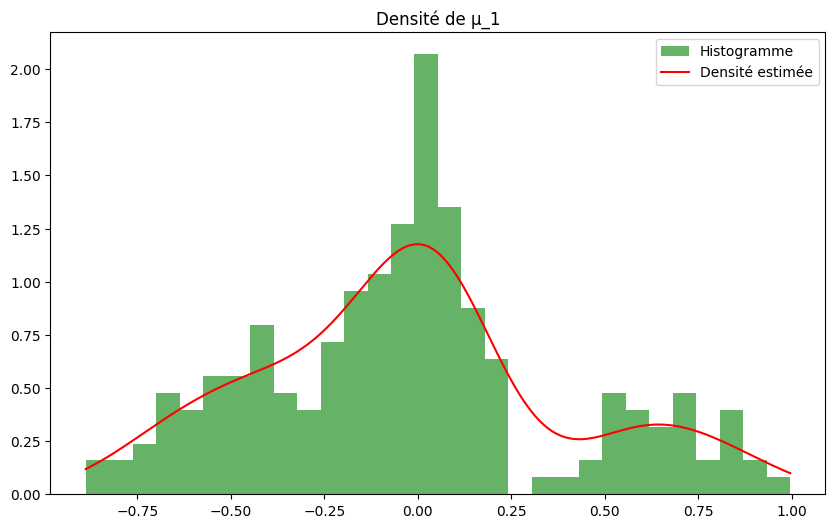

In [34]:
# Extraction et aplatissement du paramètre par1
par1 = toyG["Paramètre_1"]
par1_flat = par1.flatten()

# Estimation de la densité de probabilité
density_par1 = gaussian_kde(par1_flat)
x_vals = np.linspace(min(par1_flat), max(par1_flat), 1000)  # Générer 1000 points entre le min et le max de par1_flat
density_vals_par1 = density_par1(x_vals)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par1_flat, bins=30, density=True, alpha=0.6, color='g', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals, density_vals_par1, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de µ_1')
plt.legend()

# Afficher le graphique
plt.show()

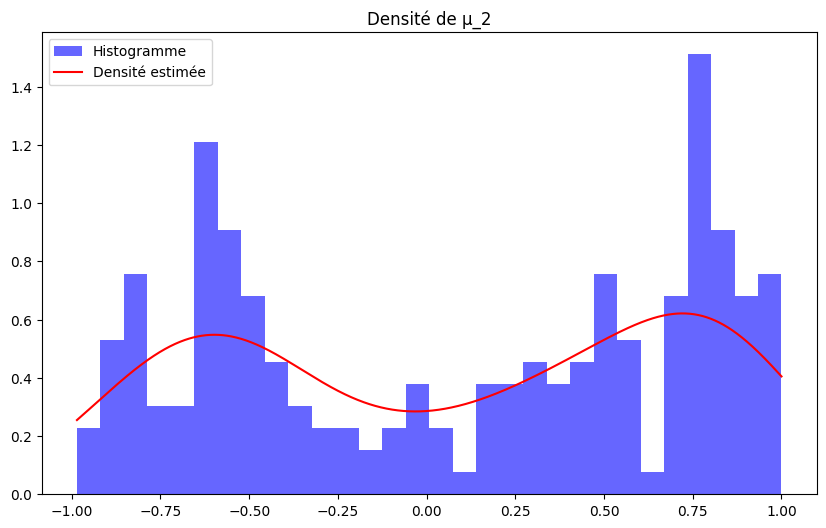

In [35]:
# Extraction et aplatissement du paramètre par2
par2 = toyG["Paramètre_2"]
par2_flat = par2.flatten()

# Estimation de la densité de probabilité
density_par2 = gaussian_kde(par2_flat)
x_vals_par2 = np.linspace(min(par2_flat), max(par2_flat), 1000)
density_vals_par2 = density_par2(x_vals_par2)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(par2_flat, bins=30, density=True, alpha=0.6, color='b', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_par2, density_vals_par2, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de µ_2')
plt.legend()

# Afficher le graphique
plt.show()

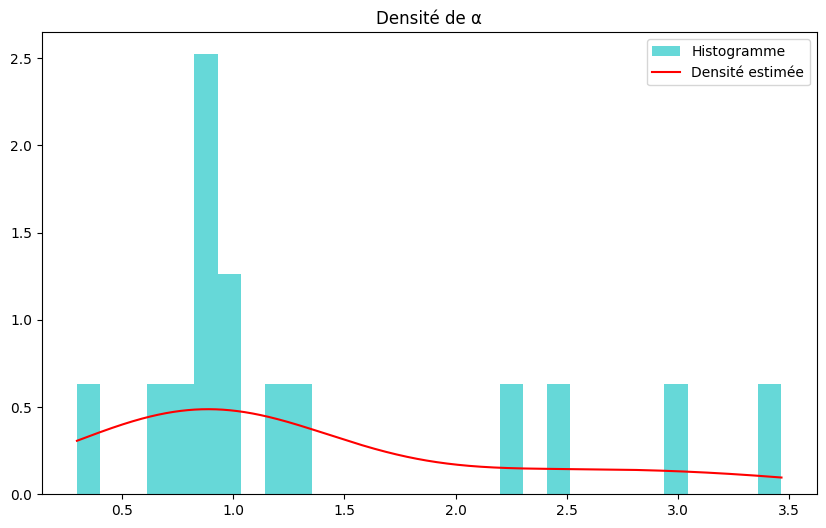

In [36]:
# Extraction et aplatissement des hyperparamètres
hyper = toyG["Hyperparamètres"]
hyper_flat = hyper.flatten()

# Estimation de la densité de probabilité
density_hyper = gaussian_kde(hyper_flat)
x_vals_hyper = np.linspace(min(hyper_flat), max(hyper_flat), 1000)
density_vals_hyper = density_hyper(x_vals_hyper)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hyper_flat, bins=30, density=True, alpha=0.6, color='c', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hyper, density_vals_hyper, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de α')
plt.legend()

# Afficher le graphique
plt.show()

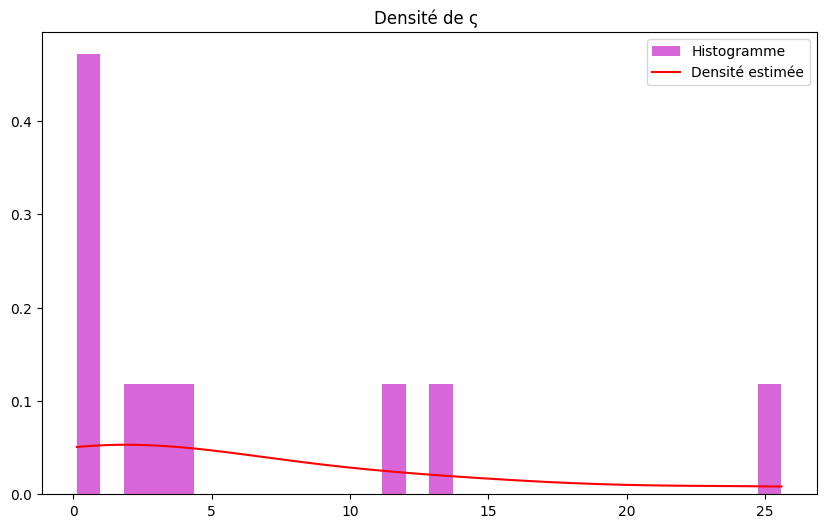

In [37]:
# Extraction et aplatissement de hypersigma
hypersigm = toyG["Hypersigma"]
hypersigm_flat = hypersigm.flatten()

# Estimation de la densité de probabilité
density_hypersigm = gaussian_kde(hypersigm_flat)
x_vals_hypersigm = np.linspace(min(hypersigm_flat), max(hypersigm_flat), 1000)
density_vals_hypersigm = density_hypersigm(x_vals_hypersigm)

# Tracer l'histogramme
plt.figure(figsize=(10, 6))
plt.hist(hypersigm_flat, bins=30, density=True, alpha=0.6, color='m', label='Histogramme')

# Tracer la densité estimée
plt.plot(x_vals_hypersigm, density_vals_hypersigm, color='r', label='Densité estimée')

# Ajouter des titres et des labels
plt.title('Densité de ς ')
plt.legend()

# Afficher le graphique
plt.show()

In [51]:
temps_max_values = range(30, 120, 30) 
standard_error_hyper = []
standard_error_hypersigma = []
distance_par1 = []
distance_hyper = []
distance_hypersigm = []

for temps_max in temps_max_values:
    resultats = GibbsABC(X, N, M, P, P2, Npts, objectifeps, temps_max)
    hyper = resultats["Hyperparamètres"]
    hypersigma=resultats["Hypersigma"]
    std_hyper = np.std(hyper, axis=0)
    std_hypersigma = np.std(hypersigma, axis=0)
    standard_error_hyper.append(standard_error_hyper)
    standard_error_hypersigma.append(standard_error_hypersigma)

    dist = distance(X, N, M, P, P2, Npts, objectifeps, temps_max, par1_real, par2_real, hyper_real, hypersigm_real)
    dist_par1=dist['Distance Paramètre 1']
    dist_hyper=dist['Distance Hyperparamètres']
    dist_hypersigm=dist['Distance Hypersigma']
    distance_par1.append(dist_par1)
    distance_hyper.append(dist_hyper)
    distance_hypersigm.append(dist_hypersigm)

# Plotting the results
plt.figure(figsize=(10, 6))
plt.plot(distance_par1, temps_max_values, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Par1')
plt.xlabel('Distance')
plt.ylabel('Temps Max (seconds)')
plt.grid(True)
plt.show()


C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:10: RuntimeWarning: divide by zero encountered in log
  return np.array([np.sum(np.log(q)), np.sum(np.log(np.abs(q - U[:, 0])))])
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:37: RuntimeWarning: divide by zero encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)
C:\Users\sarah\AppData\Local\Temp\ipykernel_19696\3082693489.py:37: RuntimeWarning: overflow encountered in divide
  y = 1 / gamma.rvs(h[0], scale=h[1], size=n)


Temps maximum d'exécution de 30 secondes atteint à l'étape 16.
Paramètre_1:
[[-8.89634246e-01  8.70225245e-03 -2.95929057e-02 -2.81734764e-03
  -8.46111570e-01 -9.14801317e-01 -9.53364661e-01  9.39340410e-01
  -3.83196690e-03  1.30711142e-03  5.58993779e-02  2.01377181e-02
  -1.38240547e-02 -5.97097494e-01  9.50293359e-02  7.53362886e-01
   7.98868256e-01 -9.22301349e-01  1.71570353e-02  9.16049299e-01
  -9.25694397e-01 -8.43329697e-03 -9.54211016e-01 -2.40376531e-02
  -8.82225124e-01 -1.21718205e-02 -7.70370334e-01 -1.97773528e-02
   6.33608601e-01  9.65893011e-01  1.94270793e-02 -9.56668108e-01
   6.92715684e-03  6.31663234e-02 -7.25488250e-02 -9.75338565e-01
  -9.44067081e-01 -9.63078848e-01 -5.99204675e-02 -8.77098287e-01
  -9.67243178e-01  9.12201303e-01  6.36767819e-04 -6.37817499e-01
   1.49622815e-02 -4.55763123e-01 -9.15076784e-01  7.40302492e-01
   5.19252416e-01  9.86462402e-01]
 [-7.79484050e-01 -1.17079213e-01 -8.34254790e-04  8.07808540e-03
  -8.59047832e-01 -8.44464580e-

KeyboardInterrupt: 

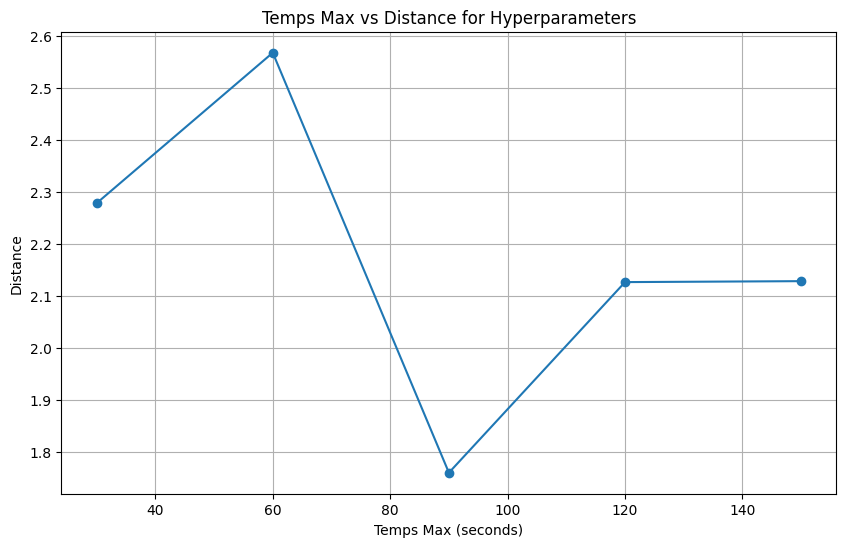

In [49]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hyper,  marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Hyperparameters')
plt.ylabel('Distance')
plt.xlabel('Temps Max (seconds)')
plt.grid(True)
plt.show()

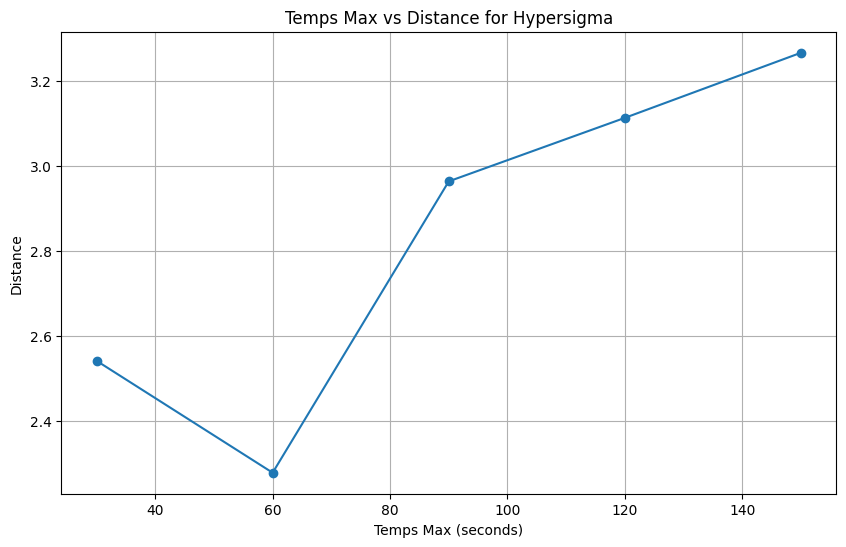

In [50]:
plt.figure(figsize=(10, 6))
plt.plot(temps_max_values, distance_hypersigm, marker='o', linestyle='-')
plt.title('Temps Max vs Distance for Hypersigma')
plt.ylabel('Distance')
plt.xlabel('Temps Max (seconds)')
plt.grid(True)
plt.show()